Matplotlib is building the font cache; this may take a moment.


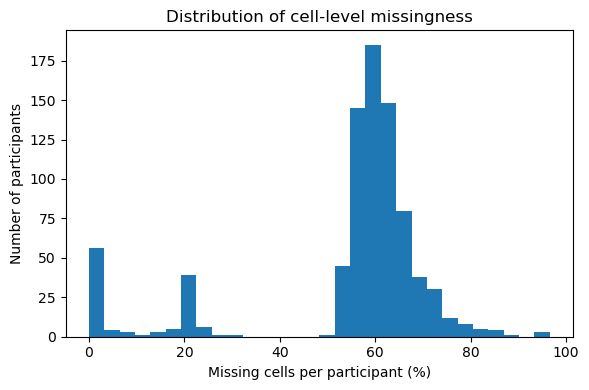

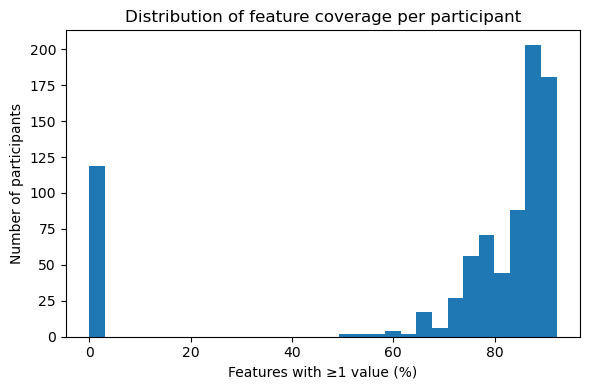

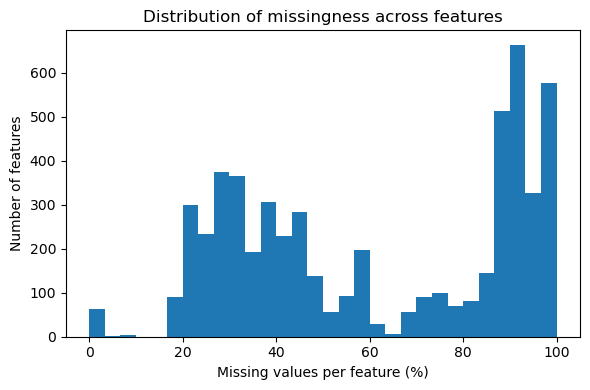

{'Participants (rows)': 824,
 'Features (columns)': 5583,
 'Median missing% per participant': np.float64(59.625),
 'Median missing% per feature': np.float64(57.8144)}

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# ---------- load the two summary tables you just created ----------
feature_info = pd.read_csv("feature_info.csv")
pid_info = pd.read_csv("missing_by_pid.csv")

# ---------- 1) Histogram of cell‑level missingness -----------------
plt.figure(figsize=(6, 4))
plt.hist(pid_info["missing_pct_cells"].dropna(), bins=30)
plt.xlabel("Missing cells per participant (%)")
plt.ylabel("Number of participants")
plt.title("Distribution of cell‑level missingness")
plt.tight_layout()
plt.show()

# ---------- 2) Histogram of feature availability ------------------
plt.figure(figsize=(6, 4))
plt.hist(pid_info["feature_pct_available"].dropna(), bins=30)
plt.xlabel("Features with ≥1 value (%)")
plt.ylabel("Number of participants")
plt.title("Distribution of feature coverage per participant")
plt.tight_layout()
plt.show()

# ---------- 3) Histogram of feature‑level missingness -------------
plt.figure(figsize=(6, 4))
plt.hist(feature_info["missing_pct"].dropna(), bins=30)
plt.xlabel("Missing values per feature (%)")
plt.ylabel("Number of features")
plt.title("Distribution of missingness across features")
plt.tight_layout()
plt.show()

# ---------- quick numeric summaries -------------------------------
summary = {
    "Participants (rows)": len(pid_info),
    "Features (columns)": len(feature_info),
    "Median missing% per participant": pid_info["missing_pct_cells"].median(),
    "Median missing% per feature": feature_info["missing_pct"].median(),
}
summary


<Axes: >

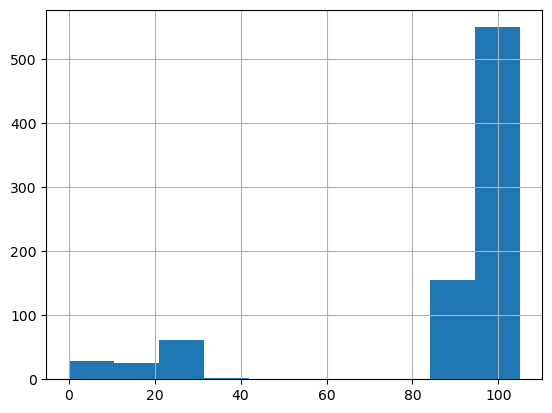

In [3]:
pid_info['n_days'].hist()

In [4]:
import pandas as pd
from pathlib import Path
from IPython.display import display

# ---- adjust this if your notebook isn't in the repo root -------------
DATA_DIR = Path(".")          # "." assumes the CSVs are next to the notebook
# DATA_DIR = Path("..")       # uncomment if CSVs live one level up

# ---------------------------------------------------------------------
feature_info = pd.read_csv(DATA_DIR / "feature_info.csv")
pid_info     = pd.read_csv(DATA_DIR / "missing_by_pid.csv")

# ---------------- apply your thresholds ------------------------------
valid_features = (
    feature_info.loc[feature_info["missing_pct"] < 50, "column"]
    .dropna()
    .loc[lambda s: s != "pid"]            # exclude identifier
    .sort_values()
)

accepted_pids = (
    pid_info[
        (pid_info["n_days"] > 80) &
        (pid_info["missing_pct_cells"] < 50) &
        (pid_info["feature_pct_available"] > 50)
    ]["pid"]
    .dropna()
    .sort_values()
)

# ---------------- save to simple lists --------------------------------
valid_features.to_csv(DATA_DIR / "valid_features.csv", index=False, header=False)
accepted_pids.to_csv(DATA_DIR / "accepted_pids.csv", index=False, header=False)

print(f"Kept {len(valid_features)} features (saved to valid_features.csv)")
print(f"Kept {len(accepted_pids)} participants (saved to accepted_pids.csv)")

# ---------------- quick preview ---------------------------------------
print("\nFirst 10 valid features:")
display(valid_features.head(10).to_frame().T)

print("\nFirst 10 accepted pids:")
display(accepted_pids.head(10).to_frame().T)


Kept 2578 features (saved to valid_features.csv)
Kept 1 participants (saved to accepted_pids.csv)

First 10 valid features:


,0,1,2,3,4,5,6,7,9,10
column,2waySSS_giving_emotional_POST,2waySSS_giving_emotional_PRE,2waySSS_giving_instrumental_POST,2waySSS_giving_instrumental_PRE,2waySSS_receiving_emotional_POST,2waySSS_receiving_emotional_PRE,2waySSS_receiving_instrumental_POST,2waySSS_receiving_instrumental_PRE,BDI2_POST,BDI2_PRE



First 10 accepted pids:


,125
pid,INS-W_162


Keeping 2578 features with <50% missingness


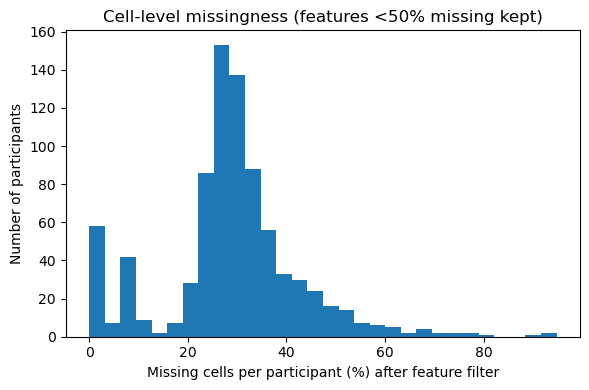

,missing_pct_cells
count,824.000000
mean,28.992439
std,14.217461
min,0.000000
25%,24.385000
50%,28.910000
75%,34.820000
max,94.830000


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from collections import Counter, defaultdict
import pandas as pd

# --------------- CONFIG -------------------------------------------------
# Location of the summary files (adj. if the notebook is elsewhere)
SUMMARY_DIR = Path(".")           # where feature_info.csv lives
# Root of the raw GLOBEM dataset  (adj. if needed)
GLOBEM_ROOT = Path("data/globem_raw")   # or Path("../data/globem_raw")

# -----------------------------------------------------------------------
# 1) Load feature summary and pick features with <50% missingness
feature_info = pd.read_csv(SUMMARY_DIR / "feature_info.csv")
keep_features = set(
    feature_info.loc[feature_info["missing_pct"] < 50, "column"]
    .dropna()
    .tolist()
)
keep_features.discard("pid")

print(f"Keeping {len(keep_features)} features with <50% missingness")

# -----------------------------------------------------------------------
# 2) Stream through all CSVs again, recompute cell-level missingness per pid
csv_files = sorted(GLOBEM_ROOT.rglob("*.csv"))
if not csv_files:
    raise FileNotFoundError(f"No CSVs found under {GLOBEM_ROOT}")

pid_seen = Counter()
pid_total = Counter()

for csv_path in csv_files:
    for chunk in pd.read_csv(csv_path, chunksize=50_000, dtype=str,
                             keep_default_na=True, na_values=["", "na", "NA"]):
        # drop leading blank/Unnamed col
        first = chunk.columns[0]
        if first.strip() == "" or first.startswith("Unnamed"):
            chunk.drop(columns=[first], inplace=True)

        # subset features
        cols_to_use = ["pid"] + [c for c in chunk.columns if c in keep_features]
        chunk = chunk[cols_to_use]

        # update counts
        mask = chunk.iloc[:, 1:].isna()   # exclude pid
        for pid, grp in mask.groupby(chunk["pid"]):
            pid_total[pid] += grp.size
            pid_seen[pid]  += grp.size - grp.values.sum()

# -----------------------------------------------------------------------
# 3) Build new DataFrame
pid_df = pd.DataFrame({
    "pid": list(pid_total.keys()),
    "missing_pct_cells": [
        round(100*(pid_total[p] - pid_seen[p]) / pid_total[p], 2)
        for p in pid_total
    ]
})

# save
pid_df.to_csv(SUMMARY_DIR / "missing_by_pid_after_feature_filter.csv", index=False)

# -----------------------------------------------------------------------
# 4) Plot histogram
plt.figure(figsize=(6,4))
plt.hist(pid_df["missing_pct_cells"], bins=30)
plt.xlabel("Missing cells per participant (%) after feature filter")
plt.ylabel("Number of participants")
plt.title("Cell-level missingness (features <50% missing kept)")
plt.tight_layout()
plt.show()

# Show quick summary stats
display(pid_df.describe())


In [10]:
import pandas as pd
from pathlib import Path

# --------- adjust these paths if needed ----------------------------------
SUMMARY_DIR = Path(".")           # location of summary CSVs
GLOBEM_ROOT = Path("data/globem_raw")   # not used here but kept for ref

# -------------------------------------------------------------------------
# 1) Load the new cell-missingness file (after feature filter)
pid_missing_new = pd.read_csv(SUMMARY_DIR / "missing_by_pid_after_feature_filter.csv")
pid_missing_new = pid_missing_new.rename(columns={"missing_pct_cells": "missing_pct_cells_filtered"})

# 2) Load the original pid summary (for n_days & feature_pct_available)
pid_orig = pd.read_csv(SUMMARY_DIR / "missing_by_pid.csv")[["pid", "n_days", "feature_pct_available"]]

# 1) Merge the two summaries as before
pid_combined = (
    pid_orig[["pid", "n_days", "feature_pct_available"]]
    .merge(pid_missing_new, on="pid", how="inner")
)

# 2) Ensure numeric dtype (invalid parsing → NaN, which will fail the filter)
for col in ["n_days", "feature_pct_available", "missing_pct_cells_filtered"]:
    pid_combined[col] = pd.to_numeric(pid_combined[col], errors="coerce")

# 3) Apply the thresholds
accepted_pids = (
    pid_combined[
        (pid_combined["n_days"] > 80) &
        (pid_combined["feature_pct_available"] > 50) &
        (pid_combined["missing_pct_cells_filtered"] < 40)
    ]["pid"]
    .dropna()
    .sort_values()
)

accepted_pids.to_csv(SUMMARY_DIR / "accepted_pids_filtered.csv",
                     index=False, header=False)

print(f"{len(accepted_pids)} participants saved to accepted_pids_filtered.csv")

576 participants saved to accepted_pids_filtered.csv


In [ ]:
pid_combined.loc[pid_combined["n_days"]>80, :]

,pid,n_days,feature_pct_available,missing_pct_cells_filtered
0,INS-W_001,93,91.17,44.15
1,INS-W_002,93,86.60,42.01
2,INS-W_003,93,89.07,23.24
3,INS-W_004,93,88.86,19.74
4,INS-W_005,93,89.39,20.87
...,...,...,...,...
802,INS-W_994,104,85.97,21.80
803,INS-W_995,104,83.34,26.62
804,INS-W_996,103,82.62,33.68
805,INS-W_998,103,89.23,36.00


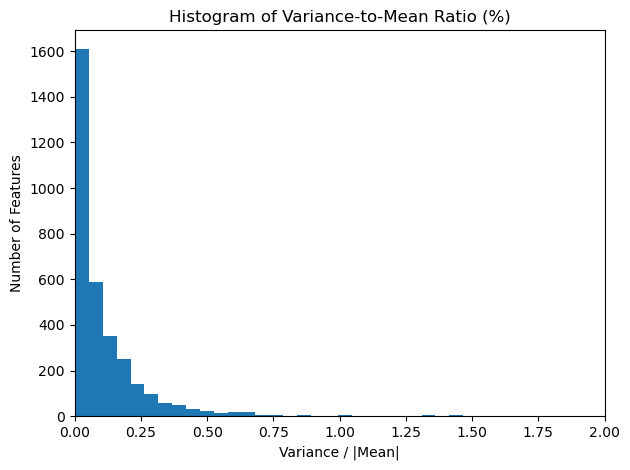

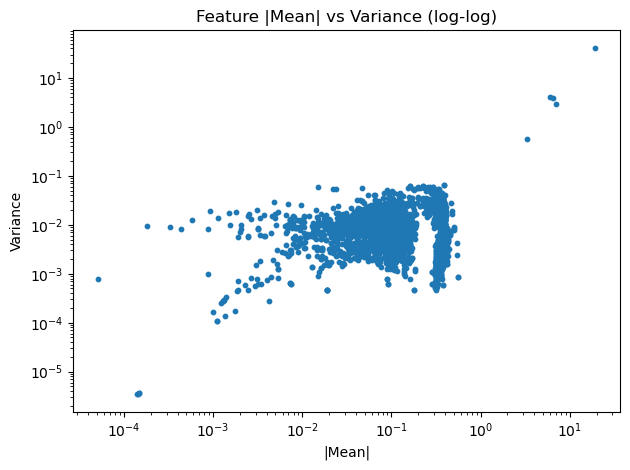

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Read the feature statistics file
stats_path = "data/processed/globem_feature_stats.csv"
if not os.path.exists(stats_path):
    raise FileNotFoundError(f"{stats_path} not found. Please upload the stats CSV.")

df = pd.read_csv(stats_path)

# Replace zero means with NaN to avoid divide‑by‑zero errors
df["mean_no_zero"] = df["mean"].replace(0, np.nan).abs()

# Calculate variance‑to‑mean ratio (as a percentage)
df["var_pct_mean"] = (df["var"] / df["mean_no_zero"])

# Drop rows where ratio could not be computed
df_ratio = df.dropna(subset=["var_pct_mean"]).copy()

# ---------------- Histogram of variance‑to‑mean ratio ----------------
plt.figure()
plt.hist(df_ratio["var_pct_mean"], bins=1000)
plt.title("Histogram of Variance‑to‑Mean Ratio (%)")
plt.xlabel("Variance / |Mean|")
plt.ylabel("Number of Features")
plt.xlim([0, 2])
plt.tight_layout()
plt.show()

# ---------------- Scatter plot: |Mean| vs Variance -------------------
plt.figure()
plt.scatter(df_ratio["mean_no_zero"], df_ratio["var"], s=10)
plt.xscale("log")
plt.yscale("log")
plt.title("Feature |Mean| vs Variance (log‑log)")
plt.xlabel("|Mean|")
plt.ylabel("Variance")
plt.tight_layout()
plt.show()